Aims:
- Label some BY4741 time series as oscillating vs non-oscillating.  50 for now, can increase when needed.
- Use this to train an SVM
- See if it can tell apart oscillating and non-oscillating time series.  Evaluate by computing a confusion matrix

Specify file name and sampling period

In [98]:
#filename_prefix = './data/arin/Omero19979_'
filename_prefix = './data/arin/Omero20016_'
sampling_period = 5
remain = 0.8

%matplotlib inline

Main

In [2]:
#!/usr/bin/env python3
import os

import numpy as np
import scipy as sp
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import sklearn.metrics
import igraph as ig

import pipeline.dataexport
import pipeline.dataimport
import pipeline.periodogram
import pipeline.score
import pipeline.tsman
import pipeline.vis

import featext.tsman
import featext.graph
#import featext.vis

#import catch22
#import leidenalg

def add_classicalAttr(cell, oversampling_factor = 1):
    """Computes classical periodogram and adds PdgramAttr attributes"""
    cell.flavin.classical.freqs, cell.flavin.classical.power = \
            pipeline.periodogram.classical(cell.time, cell.flavin.reading_processed,
                                oversampling_factor = oversampling_factor)

def add_bglsAttr(cell):
    """Computes BGLS and adds PdgramAttr attributes"""
    cell.flavin.bgls = pipeline.PdgramAttr()
    cell.flavin.bgls.label = 'Bayesian General Lomb-Scargle Periodogram'
    cell.flavin.bgls.power_label = 'Probability'
    err = np.ones(len(cell.flavin.reading_processed))*\
            np.sqrt(np.max(cell.flavin.reading_processed))
    cell.flavin.bgls.freqs, cell.flavin.bgls.power = \
            pipeline.periodogram.bgls(cell.time, cell.flavin.reading_processed, err,
                    plow = 30.0, phigh = 360.0, ofac = 5)

def add_autoregAttr(cell):
    """
    Computes autoregressive model-based periodogram and adds PdgramAttr
    attributes
    """
    cell.flavin.autoreg = pipeline.PdgramAttr()
    cell.flavin.autoreg.label = \
            'Autogressive Model-Based Periodogram (Jia & Grima, 2020)'
    cell.flavin.autoreg.power_label = 'Power'
    freq_npoints = 1000
    cell.flavin.autoreg.freqs, cell.flavin.autoreg.power = \
            pipeline.periodogram.autoreg(cell.time,
                                         cell.flavin.reading_processed,
                                         freq_npoints)

# FLAVIN: import data and process objects

# Import fluorescence info from CSVs
Dset_flavin = pipeline.dataimport.import_timeseries(
    filename_prefix+'flavin.csv', remain = remain)
# dummy so I get code to not complain; will be re-factored later
Dset_dcategory = [None] * len(Dset_flavin)
Dset_births = pipeline.dataimport.import_births(
    filename_prefix+'births.csv')

# Arranges information into DatasetAttr objects
Dset_data = pipeline.dataimport.CellAttr_from_datasets( \
        timeseries_df = Dset_flavin,
        categories_array = Dset_dcategory,
        births_df = Dset_births,
        sampling_pd = sampling_period)
Dset = pipeline.DatasetAttr(Dset_data)

# Add labels
strainlookup = pd.read_csv(filename_prefix+'strains.csv', \
                          index_col = 'position')
for ii, cell in enumerate(Dset.cells):
    cell.source = filename_prefix
    cell.medium.base = 'Delft'
    cell.medium.nutrients = {'glucose': 10}

    cell.strain = strainlookup.loc[cell.position].strain

    cell.flavin = pipeline.Fluo('flavin')
    cell.flavin.exposure = 60
    cell.flavin.reading = cell.y
    cell.flavin.category = Dset_dcategory[ii]


# mCherry: import data and process objects
try:
    Dset_mCherry_unsliced = pipeline.dataimport.import_timeseries(
        filename_prefix+'mCherry.csv', remain = remain)
    # restrict to cells with flavin readings
    idx_both = list(set(Dset_flavin.cellID) & set(Dset_mCherry_unsliced.cellID))
    Dset_mCherry = \
            Dset_mCherry_unsliced.loc[Dset_mCherry_unsliced.cellID.isin(idx_both)]

    # Arranges information into DatasetAttr objects
    # dummy -- will be better when I re-structure things... am just re-using a 
    # function for quick-and-dirty purposes, and it's obviously redundant
    mCherry_data = pipeline.dataimport.CellAttr_from_datasets( \
            timeseries_df = Dset_mCherry,
            categories_array = Dset_dcategory,
            births_df = Dset_births,
            sampling_pd = sampling_period)
    mCherry = pipeline.DatasetAttr(mCherry_data)
    mCherry_MATLABids = [cell.MATLABid for cell in mCherry.cells]

    # Add labels
    for ii, cell in enumerate(Dset.cells):
        cell.mCherry = pipeline.Fluo('mCherry')
        if cell.strain == 'htb2_mCherry_CRISPR':
            cell.mCherry.exposure = 100
        else:
            cell.mCherry.exposure = 0

        # loads in reading, cross-referencing by MATLABid.  This is awful, I know.
        if cell.MATLABid in mCherry_MATLABids:
            cell.mCherry.reading = \
                mCherry.cells[mCherry_MATLABids.index(cell.MATLABid)].y
except FileNotFoundError as error:
    print(error)
    print(f'No mCherry time series associated with this experiment: {filename_prefix}')

[Errno 2] No such file or directory: './data/arin/Omero20016_mCherry.csv'
No mCherry time series associated with this experiment: ./data/arin/Omero20016_


Define working dataset (list of cells)

In [3]:
Wlist = Dset.cells
#Wlist = [cell for cell in Dset.cells if cell.strain == 'swe1_Del']
len(Wlist)

1330

Chop up time series

In [4]:
interval_start = 0
interval_end = 168

for cell in Wlist:
    cell.time = cell.time[interval_start:interval_end]
    cell.flavin.reading = cell.flavin.reading[interval_start:interval_end]

Remove cells that have NaNs, counts number of cells in each strain

In [5]:
Wlist = [cell for cell in Wlist if not np.isnan(cell.flavin.reading).any()]
from collections import Counter
count_strain = Counter([cell.strain for cell in Wlist])
print(count_strain)

Counter({'zwf1_Del': 446, 'by4741': 222})


Normalise
(median and median absolute deviation)

In [7]:
#from scipy.stats import median_abs_deviation

for cell in Wlist:
    cell.flavin.reading_processed = (cell.flavin.reading - np.mean(cell.flavin.reading))/np.std(cell.flavin.reading)
    #cell.flavin.reading_processed = (cell.flavin.reading - np.median(cell.flavin.reading))/median_abs_deviation(cell.flavin.reading)

Detrending (by strain)
Alternatively -- whole population, but by strain seems to make more sense

In [164]:
strains = list(set([cell.strain for cell in Wlist]))

for strain in strains:
    mean_timeseries = np.mean([
        cell.flavin.reading_processed 
            for cell in Wlist
            if cell.strain == strain],
        axis = 0)
    for cell in Wlist:
        if cell.strain == strain:
            cell.flavin.reading_processed = cell.flavin.reading_processed - mean_timeseries

Define cells for training data

In [45]:
import math
import random

training_size = 50
#training_size = math.floor(0.7*len(Wlist))

Traininglist = random.choices(Wlist, k = training_size)

Define labels by scoring oscillations (human)

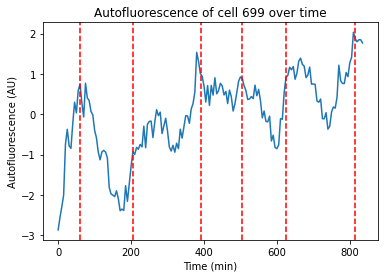

Is this oscillatory?: 1


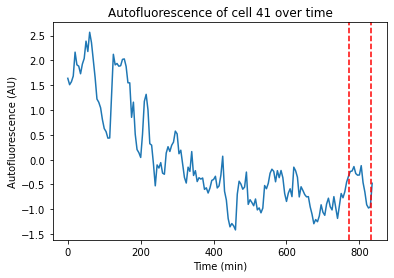

Is this oscillatory?: 0


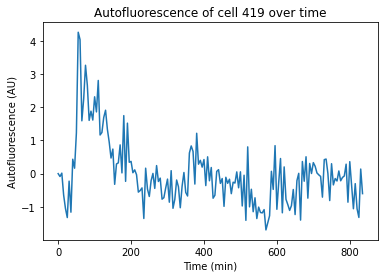

Is this oscillatory?: 0


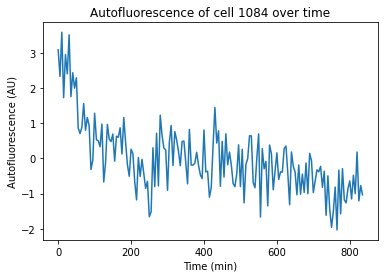

Is this oscillatory?: 0


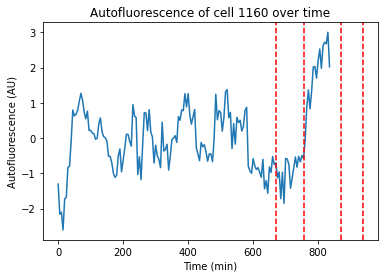

Is this oscillatory?: 0


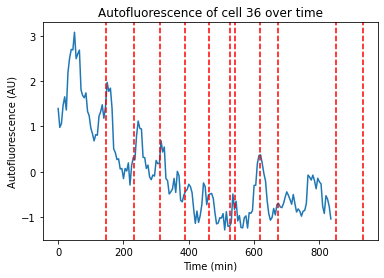

Is this oscillatory?: 1


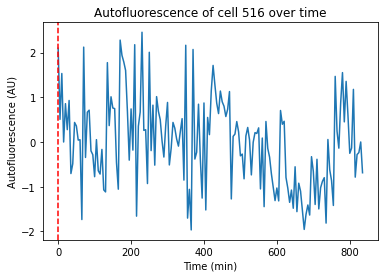

Is this oscillatory?: 0


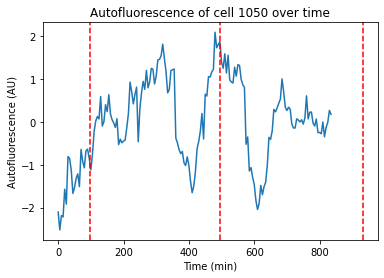

Is this oscillatory?: 0


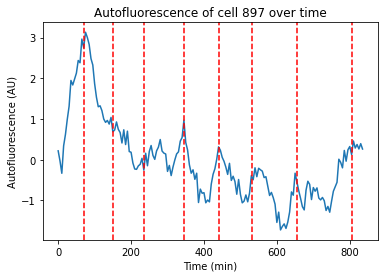

Is this oscillatory?: 1


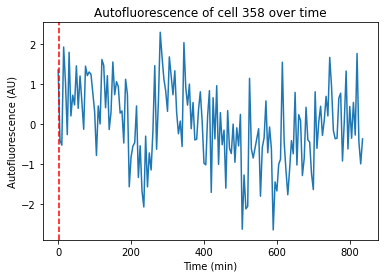

Is this oscillatory?: 0


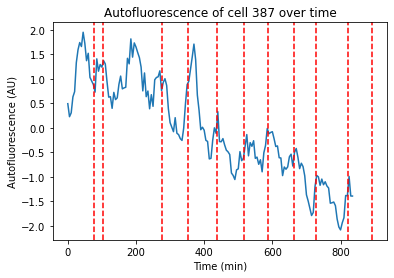

Is this oscillatory?: 1


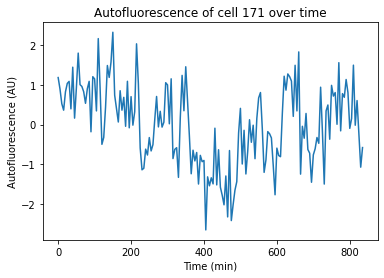

Is this oscillatory?: 0


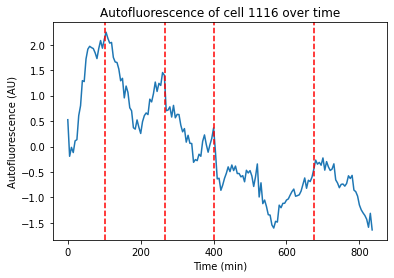

Is this oscillatory?: 1


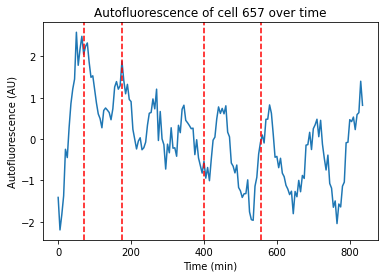

Is this oscillatory?: 1


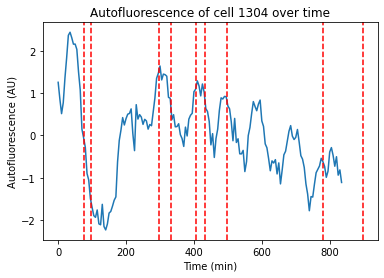

Is this oscillatory?: 1


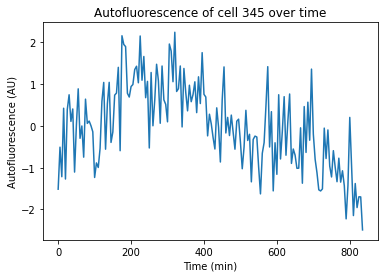

Is this oscillatory?: 0


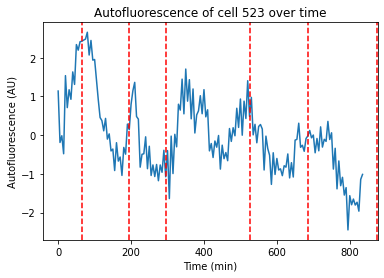

Is this oscillatory?: 1


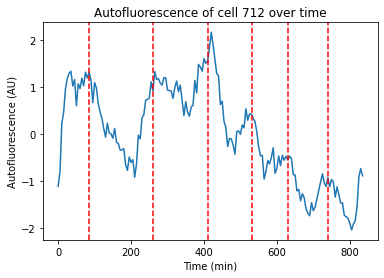

Is this oscillatory?: 1


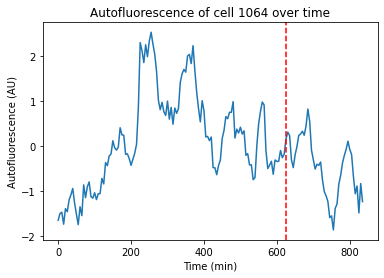

Is this oscillatory?: 1


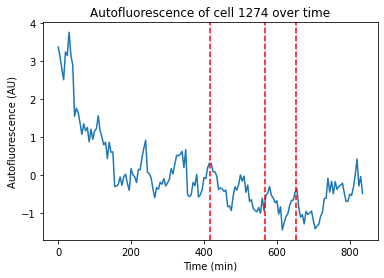

Is this oscillatory?: 1


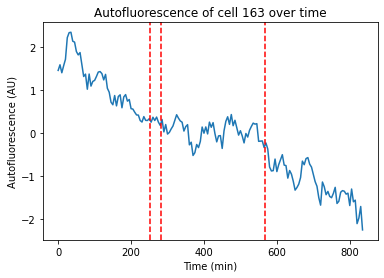

Is this oscillatory?: 0


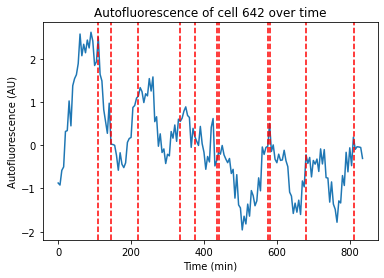

Is this oscillatory?: 1


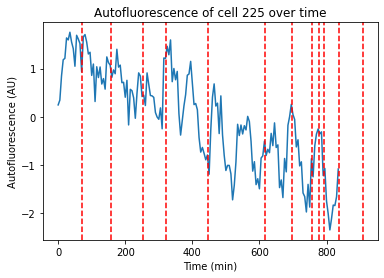

Is this oscillatory?: 1


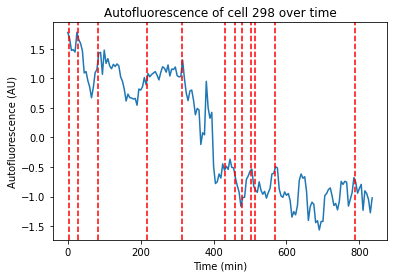

Is this oscillatory?: 0


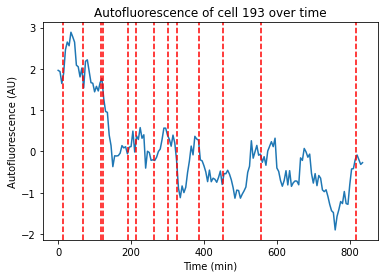

Is this oscillatory?: 1


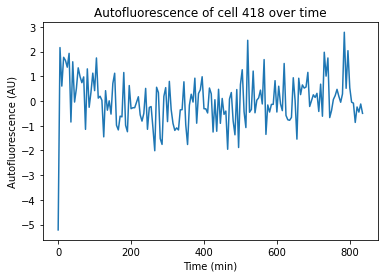

Is this oscillatory?: 0


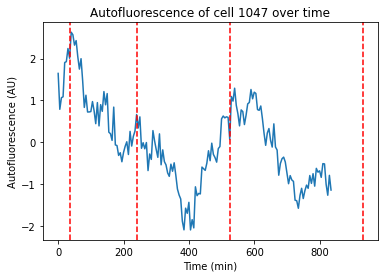

Is this oscillatory?: 0


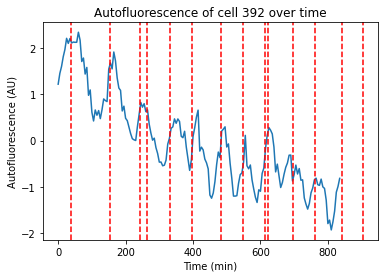

Is this oscillatory?: 1


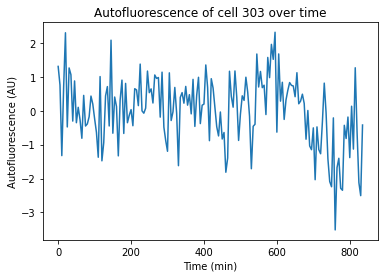

Is this oscillatory?: 0


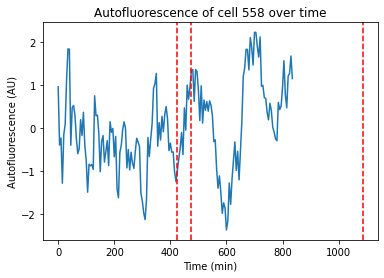

Is this oscillatory?: 0


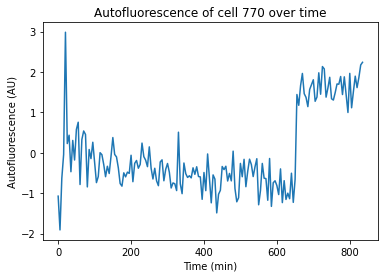

Is this oscillatory?: 0


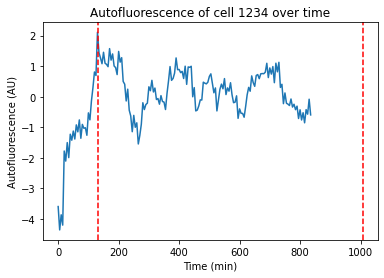

Is this oscillatory?: 0


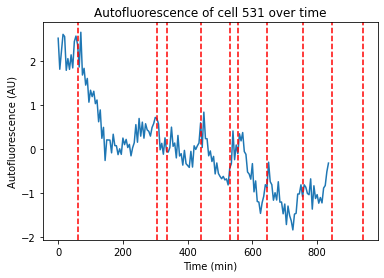

Is this oscillatory?: 0


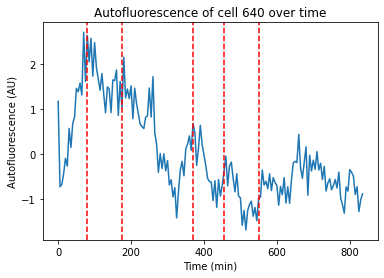

Is this oscillatory?: 0


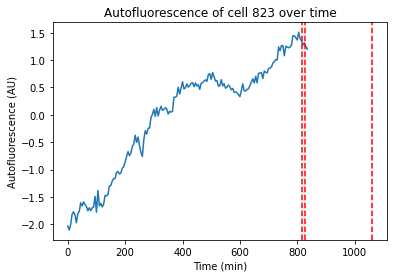

Is this oscillatory?: 0


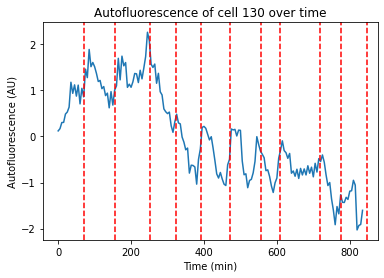

Is this oscillatory?: 1


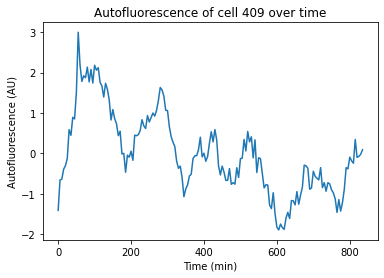

Is this oscillatory?: 1


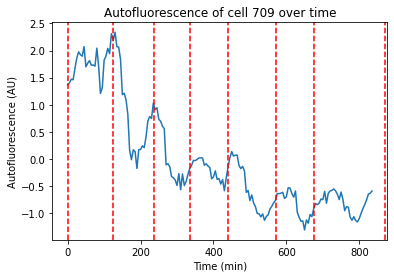

Is this oscillatory?: 1


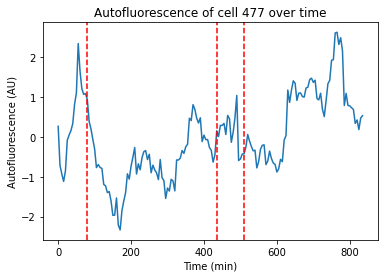

Is this oscillatory?: 1


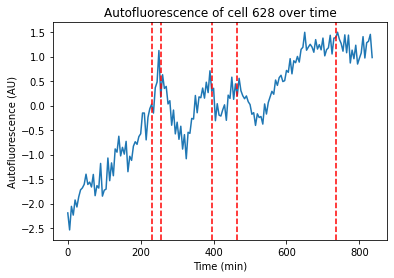

Is this oscillatory?: 0


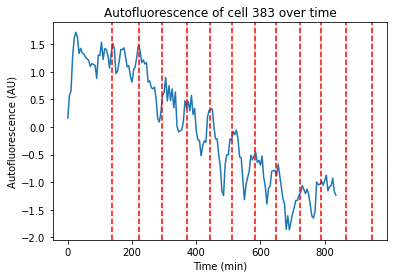

Is this oscillatory?: 1


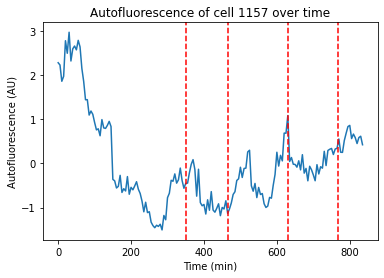

Is this oscillatory?: 1


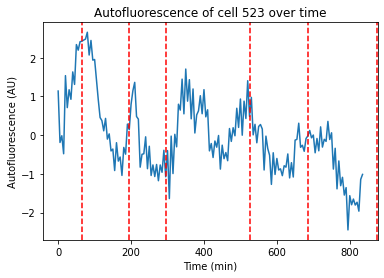

Is this oscillatory?: 1


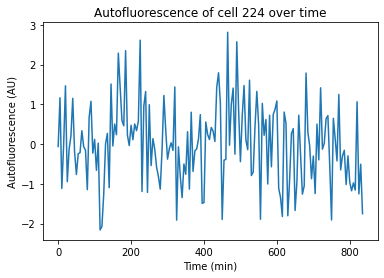

Is this oscillatory?: 0


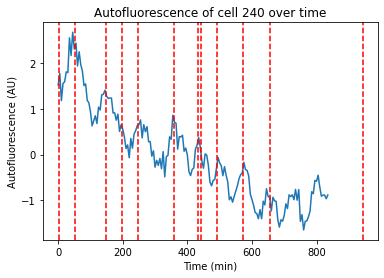

Is this oscillatory?: 1


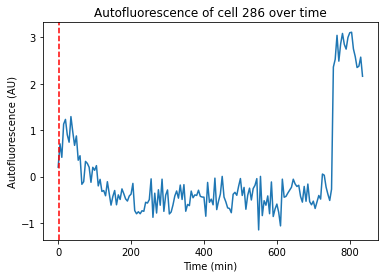

Is this oscillatory?: 0


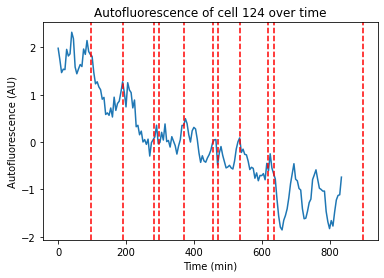

Is this oscillatory?: 1


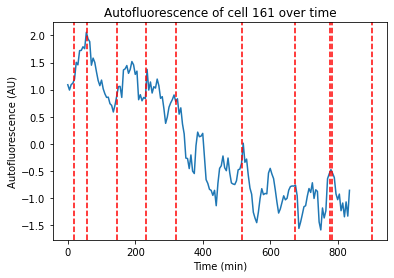

Is this oscillatory?: 1


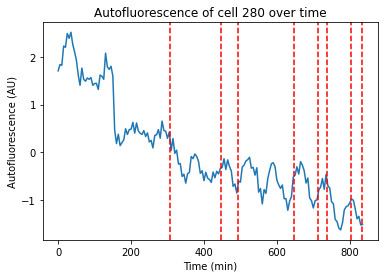

Is this oscillatory?: 1


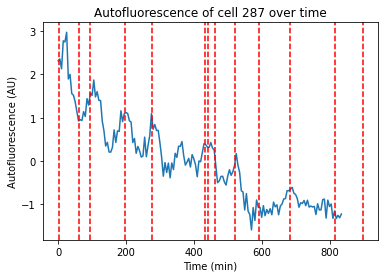

Is this oscillatory?: 1


In [46]:
for cell in Traininglist:
    cell.plot_ts(y_attr='flavin.reading_processed')
    plt.show(block=False)
    cell.flavin.category = input('Is this oscillatory?: ')

In [47]:
import pandas as pd

osc_list = [cell.flavin.category for cell in Wlist]
freq_table = pd.Series(osc_list).value_counts()
print(freq_table)

1    29
0    23
dtype: int64


Create variable to contain training data

In [48]:
training_data = np.array([cell.flavin.reading_processed for cell in Traininglist])

Create variable to contain labels

In [49]:
class_labels = np.array([cell.flavin.category for cell in Traininglist])

Alternatively, use strain names as labels

In [33]:
#strains = list(set([cell.strain for cell in Wlist]))
class_labels = np.array([cell.strain for cell in Traininglist])

Visualising training data

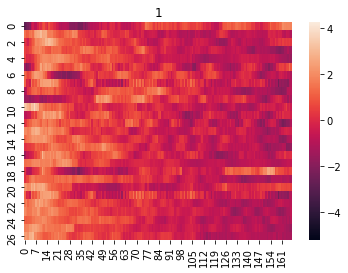

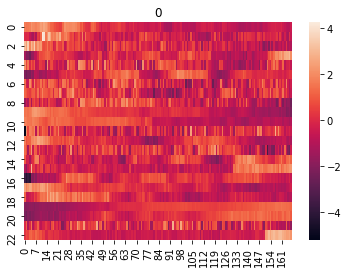

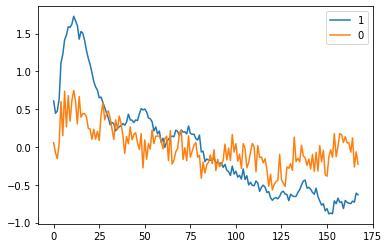

In [50]:
import seaborn as sns

for class_label in set(class_labels):
    sns.heatmap(
        [timeseries
             for index, timeseries in enumerate(training_data)
             if class_labels[index] == class_label],
        vmin = np.min(training_data),
        vmax = np.max(training_data),)
    plt.title(class_label)
    plt.show()
    
fig, ax = plt.subplots()
for class_label in set(class_labels):
    plt.plot(
        np.mean(
            [timeseries
                for index, timeseries in enumerate(training_data)
                if class_labels[index] == class_label],
            axis = 0
        ),
        label=class_label,)
plt.legend()
plt.show()

Train SVM classifier

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(training_data, class_labels)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

List predictions

In [102]:
predictions = clf.predict([cell.flavin.reading_processed for cell in Wlist])

predictions_dict = {}
for class_label in set(class_labels):
    predictions_dict[class_label] = [index
                                        for index, predicted_label in enumerate(predictions)
                                        if predicted_label == class_label]
    
print(predictions_dict)
# I checked, this doesn't just tell apart BY4741 and ZWF1 when I tell it to tell apart osc vs non-osc.
# There are some mistakes, as expected, and maybe with more training it gets better.

{'1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 128, 129, 132, 133, 135, 136, 137, 138, 140, 141, 142, 143, 144, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 174, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 201, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 220, 221, 224, 226, 227, 228, 229, 230, 235, 238, 239, 240, 243, 245, 247, 249, 250, 251, 254, 257, 258, 259, 260, 261, 262, 264, 271, 272, 273, 276, 277, 283, 285, 286, 287

Plot individual

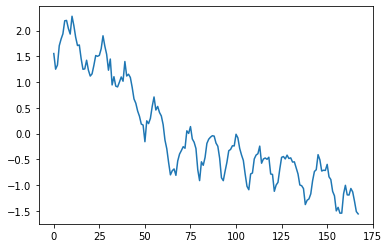

In [91]:
plt.plot(Wlist[10].flavin.reading_processed)

Plot heatmaps

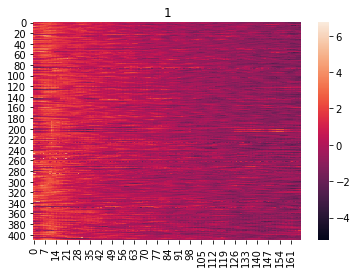

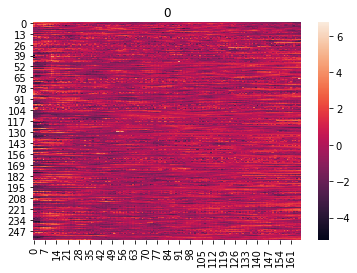

In [99]:
all_data = np.array([cell.flavin.reading_processed for cell in Wlist])
for predicted_label in set(class_labels):
    sns.heatmap(
        [cell.flavin.reading_processed
             for index, cell in enumerate(Wlist)
             if predictions[index] == predicted_label],
        vmin = np.min(all_data),
        vmax = np.max(all_data),)
    plt.title(predicted_label)
    plt.show()

Compute confusion matrix

In [100]:
# To do